# Final Project: Foundations of Data Science

## Topic: Beyond the 9 to 5: A Multivariate Analysis of Work-Life Balance, Commuting, and Job Attrition

### Team Members:
- Sitanshu Kushwaha (sak9813)
- Raunak Bhupal (rb4986)
- Milind Basavaraja (mb7949)

### Project Question/Estimand

#### Key Question:
How do work-life balance and commuting distance directly impact employee attrition, and how does job satisfaction mediate this relationship?


Dataset: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset
Assumed DAG: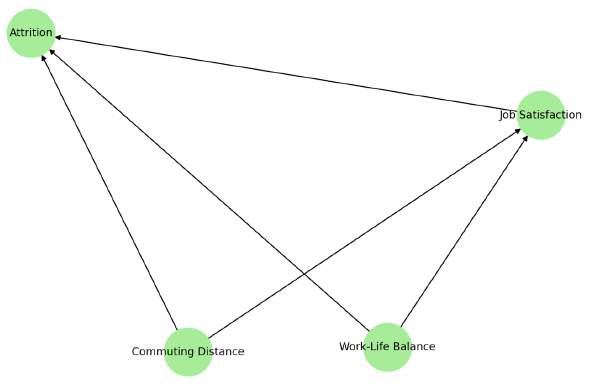


### Job Satisfaction Model Equations

1. **Priors for Job Satisfaction Model Coefficients:**
   - $$\beta_{0_{\text{js}}} \sim \text{Normal}(0, 2)$$
   - $$\beta_{1_{\text{js\_cd}}} \sim \text{Normal}(0, 2)$$

2. **Linear Model for Job Satisfaction:**
   - Job Satisfaction Index: $$\text{WLBIndex} = \text{WorkLifeBalance} - 1$$
   - Linear Model: $$\mu_{\text{js}} = \beta_{0_{\text{js}}}[\text{WLBIndex}] + \beta_{1_{\text{js\_cd}}} \times \text{DistanceFromHome}$$
   - Job Satisfaction: $$\text{JobSatisfaction} \sim \text{Normal}(\mu_{\text{js}}, 1)$$

### Attrition Model Equations

1. **Priors for Attrition Model Coefficients:**
   - $$\beta_{0_{\text{attr}}} \sim \text{Normal}(0, 2)$$
   - $$\beta_{1_{\text{attr\_cd}}} \sim \text{Normal}(0, 2)$$
   - $$\beta_{2_{\text{attr\_js}}} \sim \text{Normal}(0, 2)$$

2. **Total Effect on Attrition:**
   - Work-Life Balance Index for Attrition: $$\text{WLIndex}_{\text{attr}} = \text{WorkLifeBalance} - 1$$
   - Job Satisfaction Index for Attrition: $$\text{JSIndex}_{\text{attr}} = \text{JobSatisfaction} - 1$$
   - Total Effect: $$p = \text{logit}^{-1}(\beta_{0_{\text{attr}}}[\text{WLIndex}_{\text{attr}}] + \beta_{1_{\text{attr\_cd}}} \times \text{DistanceFromHome} + \beta_{2_{\text{attr\_js}}}[\text{JSIndex}_{\text{attr}}])$$
   - Attrition: $$\text{Attrition} \sim \text{Bernoulli}(p)$$


In [ ]:
!pip install pymc

In [ ]:
import pandas as pd
import pymc as pm
import numpy as np
from scipy.special import expit as logistic
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(1441)

In [ ]:
df = pd.read_csv("/content/WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [ ]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [ ]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [ ]:
dataset = df.loc[:, ['Attrition', 'WorkLifeBalance', 'DistanceFromHome', 'JobSatisfaction']]

In [ ]:
dataset.head()

,Attrition,WorkLifeBalance,DistanceFromHome,JobSatisfaction
0,Yes,1,1,4
1,No,3,8,2
2,Yes,3,2,3
3,No,3,3,3
4,No,3,2,2


In [ ]:
dataset['Attrition_encoded'] = dataset['Attrition'].map({"Yes" : 1, "No" : 0})

# Prior Predictive Simulation

In [ ]:
mu = 0
sigma = 2
shape = 4
samples = 100

In [ ]:
def visualize_prior(samples, title, bins=20):
    plt.figure(figsize=(10, 6))
    if samples.ndim > 1:  # For multivariate distributions
        for i in range(samples.shape[1]):
            sns.histplot(samples[:, i], kde=True, bins=bins, label=f'Level {i+1}')
    else:  # For univariate distributions
        sns.histplot(samples, kde=True, bins=bins)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

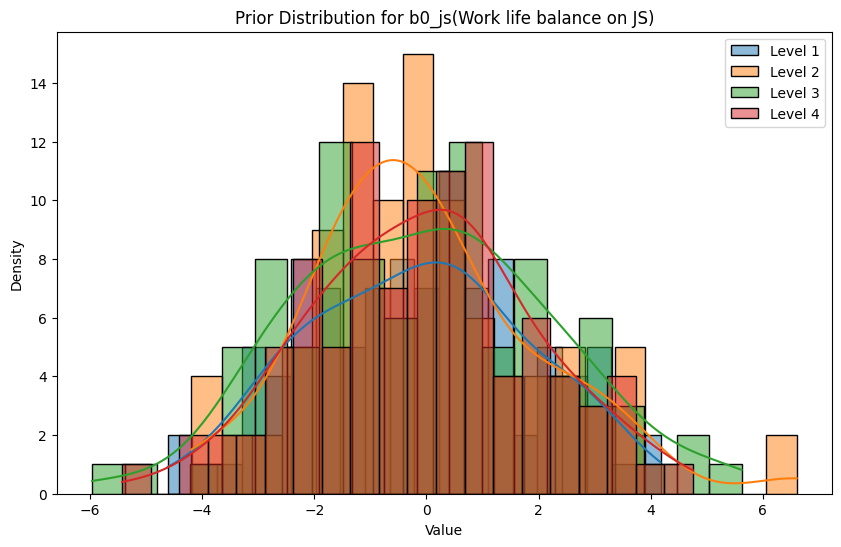

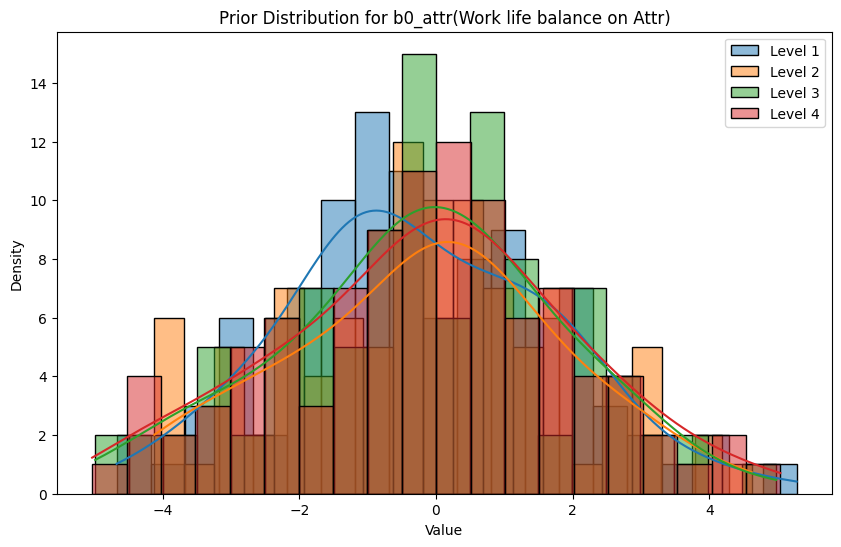

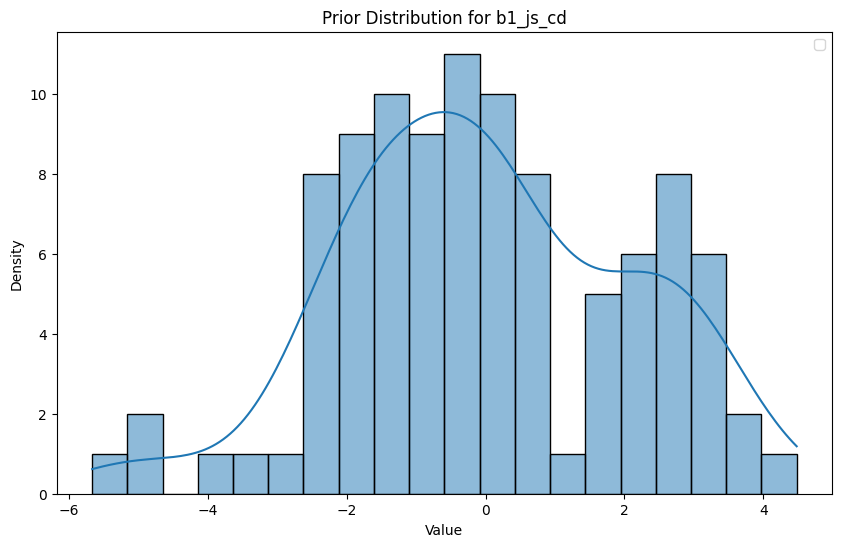

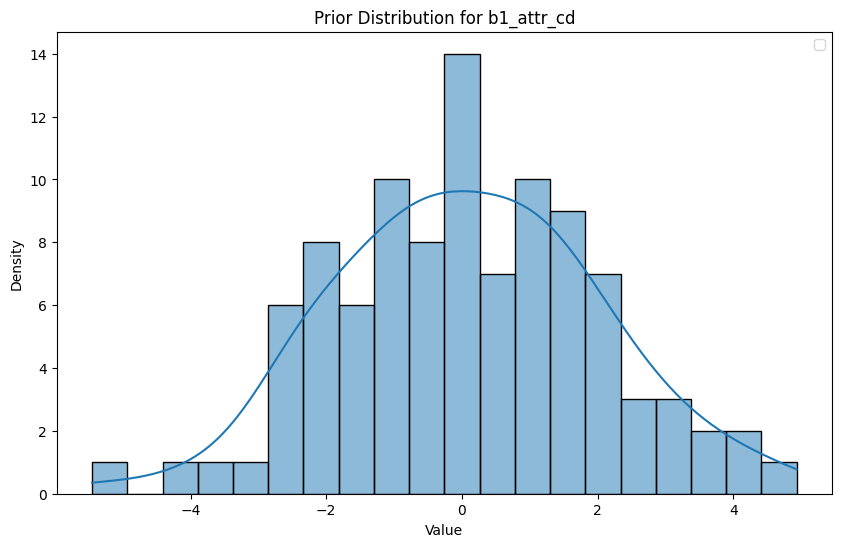

In [ ]:
# Generate and visualize priors for b0_js and b0_attr (multivariate)
prior_b0_js = np.random.normal(mu, sigma, (samples, shape))
visualize_prior(prior_b0_js, 'Prior Distribution for b0_js(Work life balance on JS)')

prior_b0_attr = np.random.normal(mu, sigma, (samples, shape))
visualize_prior(prior_b0_attr, 'Prior Distribution for b0_attr(Work life balance on Attr)')

# Generate and visualize priors for b1_js_cd and b1_attr_cd (univariate)
prior_b1_js_cd = np.random.normal(mu, sigma, samples)
visualize_prior(prior_b1_js_cd, 'Prior Distribution for b1_js_cd')

prior_b1_attr_cd = np.random.normal(mu, sigma, samples)
visualize_prior(prior_b1_attr_cd, 'Prior Distribution for b1_attr_cd')

# Testing the Model with Simulated Data


Simulating a dataset to model strong causal relationship between commuting distance and attrition using a Bayesian approach.


In [ ]:
# Simulating independent variables
n_samples = 500
work_life_balance = np.random.randint(1, 5, n_samples)  # Work-Life Balance levels (1 to 4)
commuting_distance = np.random.normal(10, 5, n_samples)  # Commuting distances

# Defining the strong positive relationship
# Coefficients for the logistic function
coef_wlb = 0.1  # Coefficient for work-life balance
coef_cd = 1.5   # High coefficient for commuting distance, indicating strong effect

# Calculating the probability of attrition
logit_p = coef_wlb * work_life_balance + coef_cd * commuting_distance
p_attrition = 1 / (1 + np.exp(-logit_p))  # Logistic function

# Generating attrition data based on probability
attrition = np.random.binomial(1, p_attrition)

# Simulating job satisfaction as well (optional, based on your model)
job_satisfaction = np.random.randint(1, 5, n_samples)  # Job Satisfaction levels (1 to 4)

# Creating a DataFrame
simulated_dataset = pd.DataFrame({
    'WorkLifeBalance': work_life_balance,
    'DistanceFromHome': commuting_distance,
    'Attrition': attrition,
    'JobSatisfaction': job_satisfaction
})

print(simulated_dataset.head())

   WorkLifeBalance  DistanceFromHome  Attrition  JobSatisfaction
0                3          3.975417          1                2
1                1          6.715018          1                3
2                3         12.167755          1                2
3                1         10.446180          1                1
4                3          1.715167          1                1


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


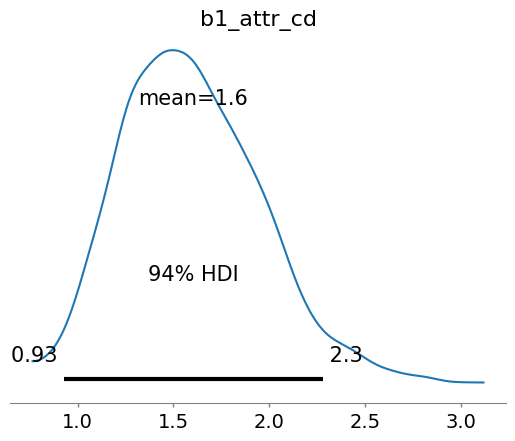

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b0_js[0]       2.445  0.124   2.200    2.674      0.004    0.003     951.0   
b0_js[1]       2.339  0.129   2.107    2.588      0.004    0.003    1051.0   
b0_js[2]       2.451  0.127   2.195    2.668      0.004    0.003    1247.0   
b0_js[3]       2.362  0.122   2.141    2.599      0.004    0.003     980.0   
b1_js_cd       0.005  0.008  -0.010    0.021      0.000    0.000     799.0   
b0_attr[0]    -0.546  1.105  -2.854    1.347      0.029    0.022    1487.0   
b0_attr[1]     1.283  1.248  -0.863    3.800      0.029    0.022    1793.0   
b0_attr[2]     0.730  1.570  -2.398    3.380      0.036    0.031    1828.0   
b0_attr[3]    -0.365  0.974  -2.296    1.382      0.027    0.021    1343.0   
b1_attr_cd     1.602  0.373   0.930    2.283      0.010    0.007    1422.0   
b2_attr_js[0] -0.085  1.178  -2.430    2.091      0.028    0.023    1804.0   
b2_attr_js[1]  1.129  1.136  -1.013    3.245      0.028    0.021

In [ ]:
with pm.Model() as model:
    # Priors
    b0_js = pm.Normal('b0_js', mu=0, sigma=2, shape=4)
    b1_js_cd = pm.Normal('b1_js_cd', mu=0, sigma=2)

    b0_attr = pm.Normal('b0_attr', mu=0, sigma=2, shape=4)
    b1_attr_cd = pm.Normal('b1_attr_cd', mu=0, sigma=1)  # Neutral prior for commuting distance
    b2_attr_js = pm.Normal('b2_attr_js', mu=0, sigma=2, shape=4)

    # Observations
    wl_balance_idx = simulated_dataset['WorkLifeBalance'] - 1
    distance_from_home = simulated_dataset['DistanceFromHome']

    # Model for Job Satisfaction
    mu_js = b0_js[wl_balance_idx] + b1_js_cd * distance_from_home
    job_satisfaction = pm.Normal('JobSatisfaction', mu=mu_js, sigma=1, observed=simulated_dataset['JobSatisfaction'])

    # Model for Attrition
    job_satisfaction_idx = simulated_dataset['JobSatisfaction'] - 1
    p = pm.math.invlogit(b0_attr[wl_balance_idx] +
                         b1_attr_cd * distance_from_home +
                         b2_attr_js[job_satisfaction_idx])
    attrition = pm.Bernoulli('Attrition', p=p, observed=simulated_dataset['Attrition'])

    trace = pm.sample(1000, tune=1000, return_inferencedata=True)

# Posterior Analysis
pm.plot_posterior(trace, var_names=['b1_attr_cd'])
plt.show()

summary = pm.summary(trace)
print(summary)

Our model is clearly able to observe the relationship of commuting distance on Attrition as intended.

# Model

In [ ]:
with pm.Model() as mediation_model:
    # Priors for Job Satisfaction model coefficients
    b0_js = pm.Normal('b0_js', mu=0, sigma=2, shape=4)  # Effects of Work-Life Balance levels on Job Satisfaction
    b1_js_cd = pm.Normal('b1_js_cd', mu=0, sigma=2)  # Effect of Commuting Distance on Job Satisfaction

    # Work-Life Balance index for Job Satisfaction
    wl_balance_idx_js = dataset['WorkLifeBalance'] - 1  # Since levels start from 1

    # Linear model for Job Satisfaction
    mu_js = b0_js[wl_balance_idx_js] + b1_js_cd * dataset['DistanceFromHome']
    job_satisfaction = pm.Normal('JobSatisfaction', mu=mu_js, sigma=1, observed=dataset['JobSatisfaction'])

    # Priors for Attrition model coefficients
    b0_attr = pm.Normal('b0_attr', mu=0, sigma=2, shape=4)  # Direct effects of Work-Life Balance levels on Attrition
    b1_attr_cd = pm.Normal('b1_attr_cd', mu=0, sigma=2)  # Direct effect of Commuting Distance on Attrition
    b2_attr_js = pm.Normal('b2_attr_js', mu=0, sigma=2, shape=4)  # Effects of Job Satisfaction levels on Attrition

    # Work-Life Balance index for Attrition
    wl_balance_idx_attr = dataset['WorkLifeBalance'] - 1  # Since levels start from 1

    # Job Satisfaction index for Attrition
    job_satisfaction_idx_attr = dataset['JobSatisfaction'] - 1  # Since levels start from 1

    # Total effect on Attrition
    p = pm.math.invlogit(b0_attr[wl_balance_idx_attr] +
                         b1_attr_cd * dataset['DistanceFromHome'] +
                         b2_attr_js[job_satisfaction_idx_attr])

    # Bernoulli model for Attrition
    attrition = pm.Bernoulli('Attrition', p=p, observed=dataset['Attrition_encoded'])

    trace_mediation_model = pm.sample(2000, tune=1000, return_inferencedata=True)


In [ ]:
summary = pm.summary(trace_mediation_model)
print(summary)

                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b0_js[0]       2.640  0.115   2.430    2.855      0.002    0.001    4250.0   
b0_js[1]       2.835  0.061   2.720    2.951      0.001    0.001    4234.0   
b0_js[2]       2.690  0.045   2.605    2.773      0.001    0.001    3535.0   
b0_js[3]       2.742  0.083   2.586    2.894      0.001    0.001    4452.0   
b1_js_cd      -0.000  0.003  -0.006    0.006      0.000    0.000    3477.0   
b0_attr[0]    -0.251  0.741  -1.589    1.141      0.024    0.017     939.0   
b0_attr[1]    -1.037  0.726  -2.371    0.322      0.024    0.017     891.0   
b0_attr[2]    -1.269  0.718  -2.534    0.119      0.024    0.017     883.0   
b0_attr[3]    -0.972  0.737  -2.357    0.400      0.024    0.017     914.0   
b1_attr_cd     0.025  0.009   0.008    0.040      0.000    0.000    4578.0   
b2_attr_js[0] -0.349  0.721  -1.677    0.976      0.024    0.017     897.0   
b2_attr_js[1] -0.773  0.723  -2.094    0.587      0.024    0.017

## Model Summary and Observations

After fitting our model to assess the impact of Work-Life Balance (WLB) and Commuting Distance (CD) on Job Satisfaction (JS) and Attrition, we obtained the following posterior estimates:

### Job Satisfaction (JS)
- The effects of WLB on JS (`b0_js`) are positive across all levels, suggesting that improvements in WLB are associated with increased job satisfaction.
- `b0_js[0]` (representing the base level of WLB, potentially 'Bad') has a posterior mean of 2.642 with a standard deviation of 0.119. The 94% Highest Density Interval (HDI) from 2.426 to 2.872 indicates a high level of certainty that the true effect is positive.
- `b0_js[1]` to `b0_js[3]` show a similar positive influence on JS, with `b0_js[1]` showing the highest mean effect (2.838).
- The effect of CD on JS (`b1_js_cd`) is negligible, with a mean very close to zero (-0.000), indicating no substantial evidence of CD impacting JS within our dataset.

### Attrition
- The direct effects of WLB on Attrition (`b0_attr`) are negative, which aligns with the expectation that better WLB is likely to reduce the probability of attrition.
- Notably, the HDIs for `b0_attr` coefficients span both positive and negative values, suggesting uncertainty about the direction of these effects. However, the means are consistently negative, ranging from -0.199 to -1.225.
- The direct effect of CD on Attrition (`b1_attr_cd`) is positive (mean = 0.025), suggesting a small but potentially significant increase in the probability of attrition with longer commuting distances.
- The coefficients `b2_attr_js` reflect the impact of JS on Attrition, with all levels showing negative means, indicating that higher JS is associated with lower attrition rates.

In summary, our model suggests that Work-Life Balance is a significant predictor of Job Satisfaction and potentially of Attrition. Commuting Distance does not appear to have a strong effect on Job Satisfaction but may slightly increase the likelihood of Attrition. Job Satisfaction itself appears to be a protective factor against Attrition.


# Analysis of the Model

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

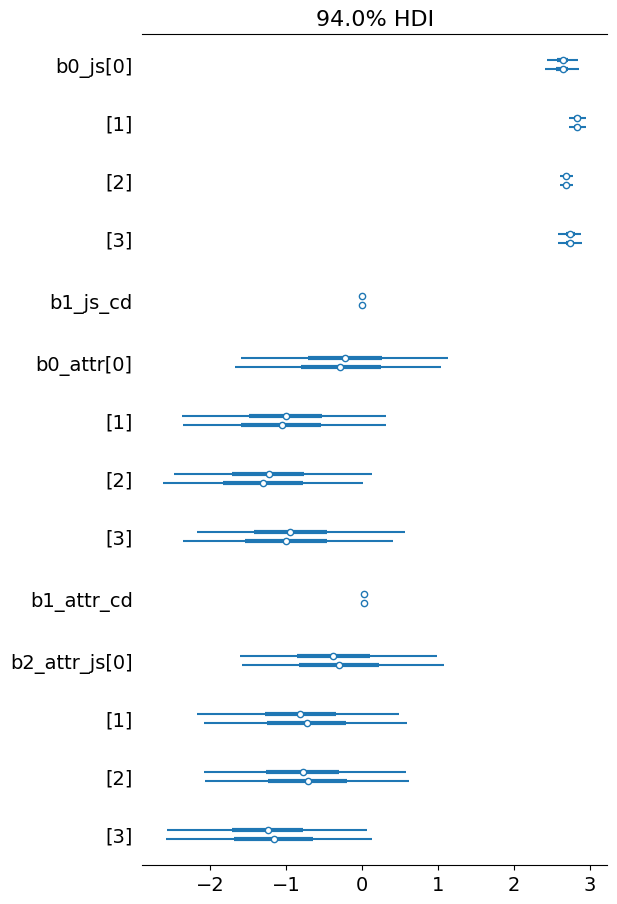

In [ ]:
az.plot_forest(trace_mediation_model)

## Interpretation of Forest Plot Results

### Impact on Job Satisfaction (JS)
- The parameters `b0_js[0]` to `b0_js[3]` represent the effect of different Work-Life Balance (WLB) levels on Job Satisfaction. The positive point estimates across these parameters suggest a general trend where higher WLB levels correspond to increased JS. Notably, the intervals do not cross zero, implying a statistically significant effect for each WLB level on JS.

### Effect of Commuting Distance
- The parameter `b1_js_cd` has a point estimate near zero with an interval that encompasses zero. This suggests that Commuting Distance has no significant effect on JS, as the data does not provide strong evidence for this relationship.

### Impact on Attrition
- The parameters `b0_attr[0]` to `b0_attr[3]` describe the direct effect of WLB levels on Attrition. With negative point estimates, the model indicates that improvements in WLB are likely associated with reduced Attrition rates. However, the wide intervals suggest a considerable amount of uncertainty around these estimates.
- The parameter `b1_attr_cd` indicates a potential positive relationship between Commuting Distance and Attrition, suggesting that longer commutes could be linked to higher Attrition. Yet, the broad interval reflects substantial uncertainty.

### Job Satisfaction's Effect on Attrition
- The parameter `b2_attr_js[0]` to `b2_attr_js[3]` shows a negative point estimate, implying that higher JS could potentially lead to lower Attrition.

In summary, the forest plot suggests significant positive effects of WLB on JS and negative effects on Attrition. The influence of Commuting Distance on JS is not evident, whereas its relationship with Attrition requires further investigation due to the high uncertainty of the estimate. Higher JS appears to be a protective factor against Attrition.

 ## Examining Coefficients

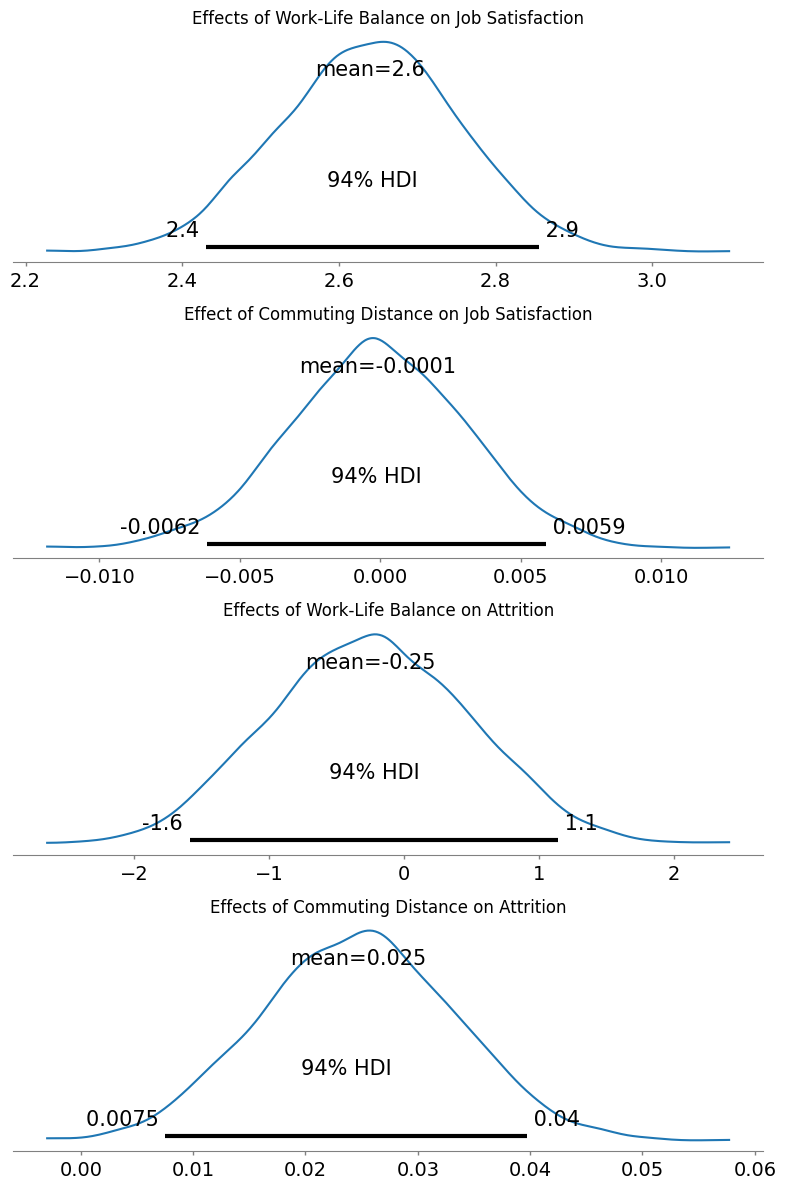

In [ ]:
# Plotting the posterior distributions for the model coefficients
_, axes = plt.subplots(4, 1, figsize=(8, 12))

# Work-Life Balance on Job Satisfaction
az.plot_posterior(trace_mediation_model, var_names=['b0_js'], ax=axes[0])
axes[0].set_title('Effects of Work-Life Balance on Job Satisfaction')

# Commuting Distance on Job Satisfaction
az.plot_posterior(trace_mediation_model, var_names=['b1_js_cd'], ax=axes[1])
axes[1].set_title('Effect of Commuting Distance on Job Satisfaction')

# Work-Life Balance on Attrition
az.plot_posterior(trace_mediation_model, var_names=['b0_attr'], ax=axes[2])
axes[2].set_title('Effects of Work-Life Balance on Attrition')

# Commuting Distance on Attrition
az.plot_posterior(trace_mediation_model, var_names=['b1_attr_cd'], ax=axes[3])
axes[3].set_title('Effects of Commuting Distance on Attrition')

plt.tight_layout()

## Posterior Distribution Interpretation

### Effects of Work-Life Balance on Job Satisfaction

- The distribution for the effect of WLB on JS is centered around a mean of 2.6, with a 94% Highest Density Interval (HDI) ranging from approximately 2.4 to 2.9.
- This suggests a high probability that improved WLB correlates positively with JS, and the effect is statistically significant since the HDI does not include zero.
- The model indicates a strong and positive influence of WLB on enhancing job satisfaction among employees.

### Effect of Commuting Distance on Job Satisfaction

- The posterior mean for the effect of CD on JS is close to zero (-0.00014), and the 94% HDI spans from about -0.0062 to 0.006.
- The HDI includes zero, which suggests that the effect of CD on JS is not statistically significant.
- The implication is that within the data, there is no clear evidence that commuting distance has a notable impact on job satisfaction.

### Effects of Work-Life Balance on Attrition

- The distribution for the effect of WLB on Attrition has a mean of -0.2, with the 94% HDI extending from approximately -1.6 to 1.2.
- Although the mean is negative, indicating that better WLB may reduce the likelihood of attrition, the HDI is quite wide and crosses zero.
- This wide interval indicates substantial uncertainty in the estimate, which suggests that the data does not provide conclusive evidence about the effect of WLB on attrition rates.

### Effects of Commuting Distance on Attrition

- The posterior distribution for the effects of Commuting Distance (CD) on Attrition is centered around a positive mean (mean=0.025), with a 94% Highest Density Interval (HDI) from approximately 0.0075 to 0.04.
- The positive mean and the fact that the HDI does not include zero suggest that there is a statistically significant effect of CD on increasing the probability of attrition.
- The model implies that as the commuting distance increases, so does the likelihood of employees considering leaving the company, potentially highlighting commute distance as a factor in job sustainability.



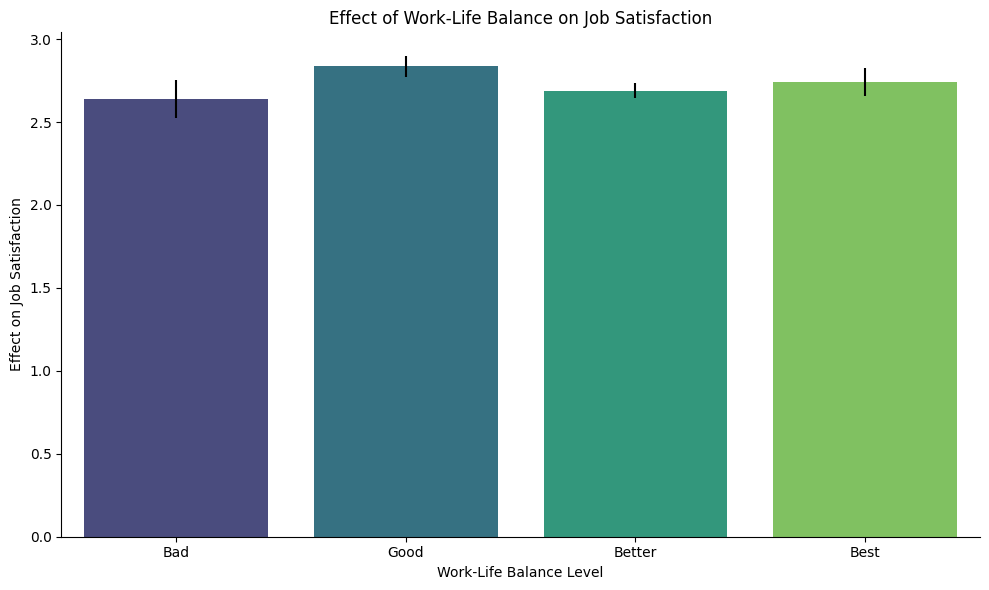

In [ ]:
wl_balance_levels = [1, 2, 3, 4]
posterior_means = np.array([trace_mediation_model.posterior['b0_js'].mean(dim=('chain', 'draw')).values[i]
                            for i in range(len(wl_balance_levels))])
posterior_stds = np.array([trace_mediation_model.posterior['b0_js'].std(dim=('chain', 'draw')).values[i]
                           for i in range(len(wl_balance_levels))])

plt.figure(figsize=(10, 6))
sns.barplot(x=wl_balance_levels, y=posterior_means, yerr=posterior_stds, palette='viridis')

plt.xticks(ticks=np.arange(len(wl_balance_levels)), labels=['Bad', 'Good', 'Better', 'Best'])
plt.xlabel('Work-Life Balance Level')
plt.ylabel('Effect on Job Satisfaction')
plt.title('Effect of Work-Life Balance on Job Satisfaction')

sns.despine()
plt.tight_layout()
plt.show()

# Contrast Plots

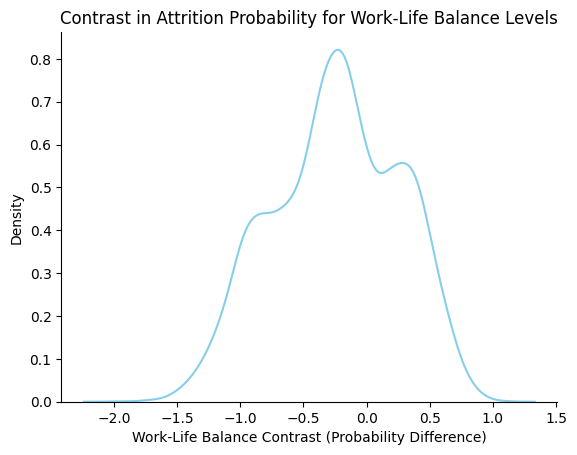

In [ ]:
# Extract Work-Life Balance coefficients samples
b0_attr_samples = trace_mediation_model.posterior['b0_attr'].values

# Calculate the difference in probabilities for adjacent levels
diff_prob_wlb = b0_attr_samples[:, :, 1:] - b0_attr_samples[:, :, :-1]

diff_prob_wlb_flat = diff_prob_wlb.reshape(-1)

sns.kdeplot(diff_prob_wlb_flat, color="skyblue")
plt.xlabel("Work-Life Balance Contrast (Probability Difference)")
plt.title("Contrast in Attrition Probability for Work-Life Balance Levels")
sns.despine()
plt.show()


### Observations
- The distribution has a peak to the left of zero, suggesting that there is a tendency for higher WLB levels to be associated with lower attrition probabilities.
- Most of the density is on the negative side of the x-axis, which implies that the model often estimates a decrease in attrition probability as WLB improves.
- The shape of the distribution suggests that the difference in attrition probability between adjacent WLB levels varies, indicating that the impact of WLB on attrition probability is not uniform across the levels.


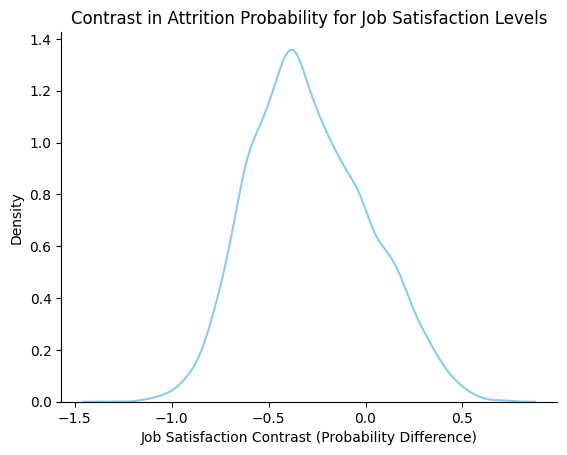

In [ ]:
# Extract Work-Life Balance coefficients samples
b2_attr_samples = trace_mediation_model.posterior['b2_attr_js'].values

# Calculate the difference in probabilities for adjacent levels
diff_prob_js = b2_attr_samples[:, :, 1:] - b2_attr_samples[:, :, :-1]

diff_prob_js_flat = diff_prob_js.reshape(-1)

sns.kdeplot(diff_prob_js_flat, color="skyblue")
plt.xlabel("Job Satisfaction Contrast (Probability Difference)")
plt.title("Contrast in Attrition Probability for Job Satisfaction Levels")
sns.despine()
plt.show()

### Observations
- The distribution is skewed to the left, with the peak of the density occurring at a negative value. This indicates that there is a trend where higher levels of JS are associated with lower probabilities of attrition.
- The most dense region being on the negative side of the x-axis suggests that moving from a lower to a higher level of JS generally corresponds with a decrease in attrition probability.

### Summary
In summary, the above contrast plot provides evidence that job satisfaction is inversely related to attrition; as job satisfaction increases, the probability of attrition decreases. The findings support the notion that enhancing job satisfaction is potentially an effective strategy for reducing attrition within the organization.

Given the plot's clear skew towards negative values, it may be beneficial for the organization to investigate which specific aspects of job satisfaction, when improved, could lead to the most significant decreases in attrition. This strategic insight can inform targeted interventions aimed at improving employee retention.


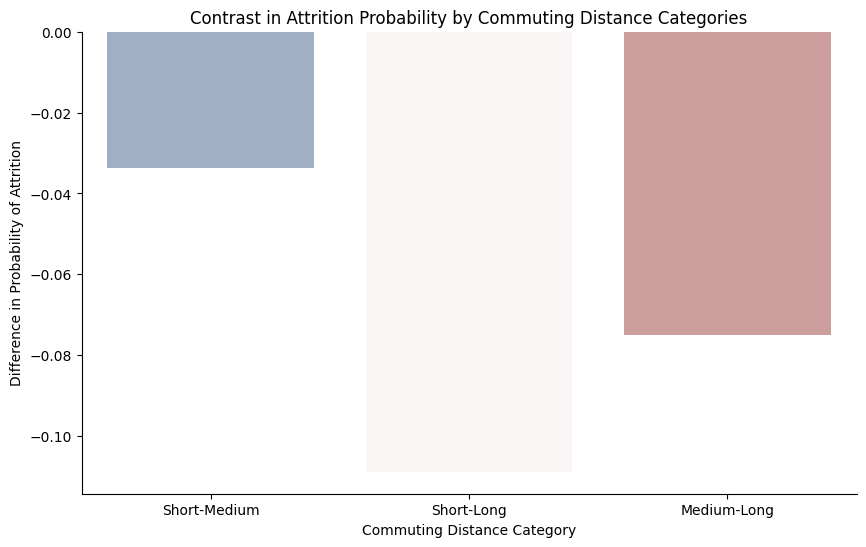

In [ ]:
distance_bins = pd.qcut(dataset['DistanceFromHome'], q=3, labels=["Short", "Medium", "Long"])
unique_bins = distance_bins.cat.categories

# Extract Coefficient Samples for Commuting Distance
b1_attr_cd_samples = trace_mediation_model.posterior['b1_attr_cd'].values

prob_diff = {}
for i, cat1 in enumerate(unique_bins):
    for j, cat2 in enumerate(unique_bins):
        if i < j:
            # Mean distance for each category
            mean_dist_cat1 = dataset[distance_bins == cat1]['DistanceFromHome'].mean()
            mean_dist_cat2 = dataset[distance_bins == cat2]['DistanceFromHome'].mean()

            # Calculate the difference in probabilities between categories
            diff = pm.math.invlogit(b1_attr_cd_samples * mean_dist_cat1) - pm.math.invlogit(b1_attr_cd_samples * mean_dist_cat2)

            prob_diff[f'{cat1}-{cat2}'] = np.mean(diff.eval())

contrast_df = pd.DataFrame(list(prob_diff.items()), columns=['Distance Category', 'Probability Difference'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Distance Category', y='Probability Difference', data=contrast_df, palette="vlag")
plt.title('Contrast in Attrition Probability by Commuting Distance Categories')
plt.ylabel('Difference in Probability of Attrition')
plt.xlabel('Commuting Distance Category')
sns.despine()
plt.show()

Each bar in the plot represents a pair of categories, and the height of the bar shows the difference in attrition probability between those two categories.

### Interpretation of the Bars

- **Short-Medium**: The bar is negative, which suggests that the predicted probability of attrition for the 'Medium' commuting distance category is higher than for the 'Short' category. The exact value on the y-axis shows the magnitude of the difference.

- **Short-Long**: This bar is also negative and its length indicates that the 'Long' commuting distance category has an even higher predicted probability of attrition compared to the 'Short' category. The difference here is greater than between 'Short' and 'Medium', as shown by the longer bar.

- **Medium-Long**: Again, the bar is negative and indicates an increase in the predicted probability of attrition when moving from the 'Medium' to the 'Long' commuting distance category.

Overall, the plot suggests that as commuting distance increases (from short to medium to long), there is a trend toward a higher probability of attrition. The negative values indicate that longer commute distances are associated with a higher likelihood of employees leaving the company, which could imply that commute stress or related factors might contribute to employees' decisions to leave.

## Concluding Remarks: Impact of Work-Life Balance and Commuting Distance on Attrition with the Mediating Role of Job Satisfaction

This analysis explored the influence of Work-Life Balance (WLB) and Commuting Distance (CD) on employee attrition, with a particular focus on how Job Satisfaction (JS) mediates these relationships.

### Key Findings

- **Work-Life Balance**: Higher levels of WLB are strongly associated with increased job satisfaction. While the effects of WLB on attrition are negative (suggesting that better WLB might reduce attrition), the wide confidence intervals indicate substantial uncertainty. This implies that WLB's direct impact on attrition may be complex and influenced by additional factors not captured in the model.

- **Commuting Distance**: The analysis indicates a statistically significant effect of CD on increasing attrition probability, with longer commutes correlating with a greater likelihood of employee turnover. However, CD does not appear to have a notable direct impact on job satisfaction.

- **Job Satisfaction**: Higher job satisfaction levels are generally associated with lower probabilities of attrition.

The findings highlight the importance of a holistic approach that considers both direct and indirect factors contributing to attrition, with job satisfaction serving as a key mediator in the dynamics of employee turnover.

